!!!!!! TODO:

lalwaveform.lalsim_fd_waveform incorectly sets uses hp and hc in setting Waveform.from_hp_hc. The function should be renamed Waveform.from_real_imag, and you should input ~hp + i*~hc. You are sort of doing this, but make sure it's correct.

Also you are inputing ~hp + i~hc as the data ~h instead of Fphp + Fc*hc. This is why your amplitude is too large.

!!!!!!


In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.optimize as optimize

Populating the interactive namespace from numpy and matplotlib


In [2]:
np.set_printoptions(precision=4, linewidth=150)

In [3]:
import lal
import lalsimulation

import pycbc.filter
#import pycbc.waveform
import pycbc.types
import pycbc.psd

In [4]:
import matplotlib
matplotlib.__version__

'2.0.0rc1'

In [13]:
sys.path.insert(0, '../src')

import waveform as wave
import waveformset as ws
import trainingset as train
import taylorf2
import gaussianprocessregression as gpr
import designofexperiment as doe
#import pycbcwaveform as pycbcwave
import lalwaveform
import plotparams
import greedy
import empiricalinterpolation as eim
import surrogate
import diagnostics
import fisher

import imp
imp.reload(wave)
imp.reload(ws)
imp.reload(train)
imp.reload(taylorf2)
imp.reload(gpr)
imp.reload(doe)
#imp.reload(pycbcwave)
imp.reload(lalwaveform)
imp.reload(greedy)
imp.reload(eim)
imp.reload(surrogate)
imp.reload(diagnostics)
imp.reload(fisher)

import constants
imp.reload(constants)
from constants import *

# Functions for constructing surrogate

In [8]:
# def physical_to_pycbc_frequency_series(freq, h_plus, h_cross):
#     """Convert numpy arrays to pycbc frequency series.
#     """
#     delta_f = freq[1]-freq[0]
#     hp_fs = pycbc.types.FrequencySeries(h_plus, delta_f=delta_f)
#     hc_fs = pycbc.types.FrequencySeries(h_cross, delta_f=delta_f)
#     return hp_fs, hc_fs

In [64]:
# class GPSurrogate(object):
#     def __init__(self, Bamp, Bphase, damp_gp_list, dphase_gp_list):
#         # Lists of interpolating functions
#         self.Bamp = Bamp
#         self.Bphase = Bphase
#         # Lists of GPR functions
#         self.damp_gp_list = damp_gp_list
#         self.dphase_gp_list = dphase_gp_list
#         # Waveform samples
#         self.mf = self.Bamp[0].x
#         self.mf_a = self.Bamp[0].x[0]
#         self.mf_b = self.Bamp[0].x[-1]
        
#     @classmethod
#     def load(cls, Bamp_filename, Bphase_filename, damp_gp_filename, dphase_gp_filename):
#         """Load surrogate model from 4 hdf5 data files.
#         """
#         Bamp = ws.HDF5WaveformSet(Bamp_filename)
#         Bphase = ws.HDF5WaveformSet(Bphase_filename)
#         damp_gp_list = gpr.load_gaussian_process_regression_list(damp_gp_filename)
#         dphase_gp_list = gpr.load_gaussian_process_regression_list(dphase_gp_filename)
#         return GPSurrogate(Bamp, Bphase, damp_gp_list, dphase_gp_list)
    
#     ############# Evaluate waveform quantities in geometric units #############
    
#     def geometric_reference_waveform(self, params, npoints=10000):
#         """Reference TaylorF2 waveform in geometric units
#         evaluated at the same times as the surrogate of the difference.
#         """
#         q, s1, s2, lambda1, lambda2 = params
#         h_ref = taylorf2.dimensionless_taylorf2_waveform(
#             mf=self.mf, q=q, 
#             spin1z=s1, spin2z=s2, 
#             lambda1=lambda1, lambda2=lambda2)
 
#         # Reference waveform has zero starting phase
#         h_ref.add_phase(remove_start_phase=True)
#         return h_ref
    
#     def amp_phase_difference(self, params):
#         """Evaluate the surrogates for the differences \Delta\Phi and \Delta\ln A.
#         """
#         return surrogate.reconstruct_amp_phase_difference(
#             params, self.Bamp, self.Bphase, 
#             self.damp_gp_list, self.dphase_gp_list)
    
#     def geometric_waveform(self, params):
#         """Combine the reference waveform and surrogates for the differences.
#         """
#         # Surrogate of \Delta\Phi and \Delta\ln A
#         h_diff_sur = self.amp_phase_difference(params)
#         # Reference waveform
#         h_ref = self.geometric_reference_waveform(params)
#         # Surrogate of A and \Phi
#         h_sur = h_ref.copy()
#         h_sur.amp *= np.exp(h_diff_sur.amp)
#         h_sur.phase += h_diff_sur.phase
#         return h_sur
    
#     ################### Evaluate waveform in physical units ##################
    
#     def physical_waveform_zero_inclination(
#         self, mass1=None, mass2=None, 
#         spin1z=None, spin2z=None, 
#         lambda1=None, lambda2=None,
#         distance=None):
#         """Waveform in physical units with zero inclination.
#         Useful when you want a Waveform object without re-decomposing 
#         into amplitude and phase. This is cheap to evaluate.
        
#         Check parameters and convert them to be used by the surrogate waveform model.
#         """
        
#         ################# Check parameter range #################
#         if spin1z < -0.7 or spin1z > 0.7 or spin2z < -0.7 or spin2z > 0.7:
#             raise ValueError('Valid spins: spin1z in [-0.7, 0.7], spin2z in [-0.7, 0.7]')
#         if lambda1 < 0 or lambda1 > 10000 or lambda2 < 0 or lambda2 > 10000:
#             raise ValueError('Valid tidal parameter range: lambda1 in [0, 10000], lambda2 in [0, 10000]')
        
#         # If mass1 is not the larger mass, swap (mass1, mass2), (spin1z, spin2z), and (lambda1, lambda2)
#         if mass1 < mass2:
#             mass1, mass2 = mass2, mass1
#             spin1z, spin2z = spin2z, spin1z
#             lambda1, lambda2 = lambda2, lambda1
        
#         if mass2 < 1.0:
#             raise ValueError('Mass of less massive star must be >= 1M_sun.')
            
#         q = mass2/mass1
#         if q < 1.0/3.0 or q > 1.0:
#             raise ValueError('Valid mass ratio range: q in [1/3, 1].')
        
#         ########## Evaluate waveform #########
#         mtot = mass1 + mass2
#         params = np.array([q, spin1z, spin2z, lambda1, lambda2])
#         h_geom = self.geometric_waveform(params)
#         h_phys = wave.dimensionless_to_physical_freq(h_geom, mtot, distance)
#         return h_phys       
        
#     def physical_waveform_lal(
#         self, mass1=None, mass2=None, 
#         spin1z=None, spin2z=None, 
#         lambda1=None, lambda2=None,
#         distance=None, inclination=None, 
#         f_min=None, f_max=None, delta_f=None, 
#         f_ref=None, phi_ref=None):
#         """Waveform in lalsimulation format with data in arrays.
#         !!!! TODO: phi_ref is the phase at f_ref. These are not currently set. !!!!
        
#         Parameters
#         ----------
#         **kwargs : All arguments of self.physical_waveform_zero_inclination
#         """
#         ################# Check parameter range #################
#         mtot = mass1 + mass2
#         mf_min = f_to_mf(f_min, mtot)
#         mf_max = f_to_mf(f_max, mtot)
#         if mf_min < self.mf_a or mf_min > self.mf_b:
#             raise ValueError('f_min or f_max outside allowed range.')
        
#         ########## Evaluate waveform using LALSimulation convention #########
#         #    --Uniformly spaced frequencies in [0, f_max).
#         #    --Data is zero below max(f_min, first data point in h_geom) and
#         #     zero above min(f_max, last data point in h_geom).
        
#         h_phys = self.physical_waveform_zero_inclination(
#             mass1=mass1, mass2=mass2, 
#             spin1z=spin1z, spin2z=spin2z, 
#             lambda1=lambda1, lambda2=lambda2,
#             distance=distance)
        
#         # Initialize arrays. The output is zero below f_min.
#         freq = np.arange(0.0, f_max, delta_f)
#         h_plus = np.zeros(len(freq), dtype=complex)
#         h_cross = np.zeros(len(freq), dtype=complex)
        
#         # Find the nonzero elements
#         f_min_nonzero = max(f_min, h_phys.x[0])
#         f_max_nonzero = min(f_max, h_phys.x[-1])
#         # Can't compare arrays with 'and'. Have to use bitwise '&' instead.
#         i_nonzero = np.where((freq>=f_min_nonzero) & (freq<=f_max_nonzero))
#         freq_nonzero = freq[i_nonzero]
        
#         # Amplitude and phase in the nonzero region
#         amp = h_phys.interpolate('amp')(freq_nonzero)
#         phase = h_phys.interpolate('phase')(freq_nonzero)
        
#         inc_plus = 0.5*(1.0+np.cos(inclination)**2)
#         inc_cross = np.cos(inclination)
        
#         h_plus[i_nonzero] = inc_plus * 0.5*amp*np.exp(1.0j*phase)
#         h_cross[i_nonzero] = inc_cross * 0.5*amp*np.exp(1.0j*(phase+np.pi/2.0))
#         return freq, h_plus, h_cross
        
#     def physical_waveform_pycbc(self, **kwargs):
#         """Waveform in pycbc format
        
#         Parameters
#         ----------
#         **kwargs : All arguments of self.physical_waveform_lal
#         """
#         freq, h_plus, h_cross = self.physical_waveform_lal(**kwargs)
#         hp_fs, hc_fs = physical_to_pycbc_frequency_series(freq, h_plus, h_cross)
#         return hp_fs, hc_fs

# Test GPSurrogate class

In [14]:
Bamp_filename = '../data/Bamp.hdf5'
Bphase_filename = '../data/Bphase.hdf5'
damp_gp_filename = '../data/amp_gp.hdf5'
dphase_gp_filename = '../data/phase_gp.hdf5'
sur = surrogate.GPSurrogate.load(Bamp_filename, Bphase_filename, damp_gp_filename, dphase_gp_filename)

In [15]:
trainset = ws.HDF5WaveformSet('../data/h_training_set.hdf5')
testset_rand = ws.HDF5WaveformSet('../data/h_test_set_rand.hdf5')
testset_uni = ws.HDF5WaveformSet('../data/h_test_set_uniform.hdf5')

[  9.9356e-01  -5.4233e-01   2.6339e-01   9.1185e+02   7.7988e+03]


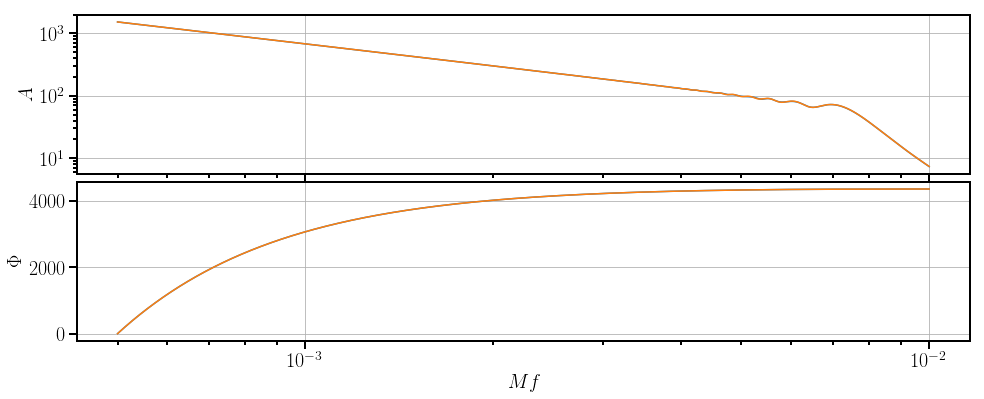

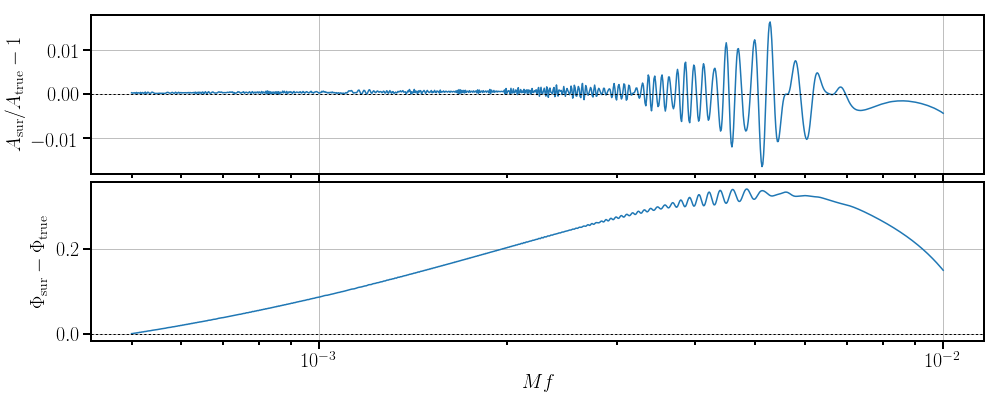

In [16]:
i = 99
params = testset_rand.get_waveform(i, data='parameters')
print params

h_true = testset_rand[i]
h_sur = sur.geometric_waveform(params)

# Plot h_true and h_sur
fig, (ax1, ax2) = wave.plot_waveforms_fd([h_sur, h_true])
ax1.set_yscale('log')
ax1.set_ylabel(r'$A$')
ax2.set_ylabel(r'$\Phi$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

# Plot error
fig, (ax1, ax2) = wave.plot_waveform_difference_fd(h_sur, h_true, xi=None, xf=None, npoints=1000)
ax1.set_ylabel(r'$A_{\rm sur}/A_{\rm true} - 1$')
ax2.set_ylabel(r'$\Phi_{\rm sur} - \Phi_{\rm true}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

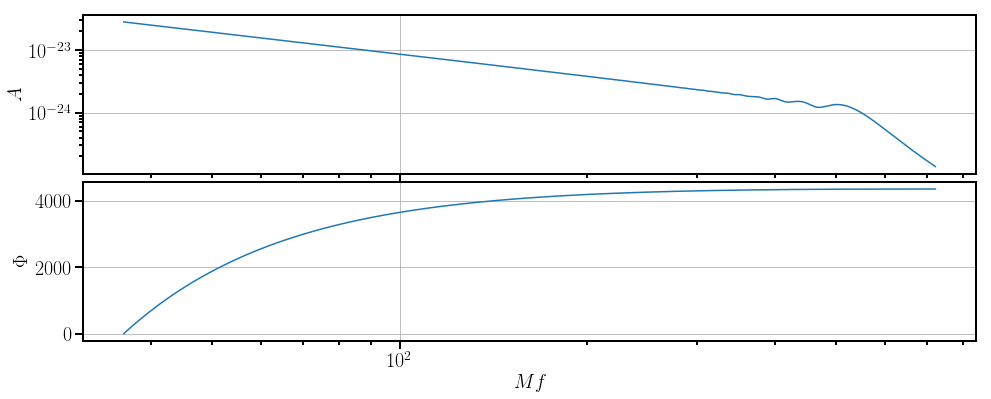

In [17]:
q, spin1z, spin2z, lambda1, lambda2 = params
mass2 = 1.4
mass1 = mass2/q
distance = 100.

h_phys = sur.physical_waveform_zero_inclination(
    mass1=mass1, mass2=mass2, 
    spin1z=spin1z, spin2z=spin2z, 
    lambda1=lambda1, lambda2=lambda2,
    distance=distance)

fig, (ax1, ax2) = wave.plot_waveforms_fd([h_phys])
ax1.set_yscale('log')
ax1.set_ylabel(r'$A$')
ax2.set_ylabel(r'$\Phi$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

(10.0, 1000.0)

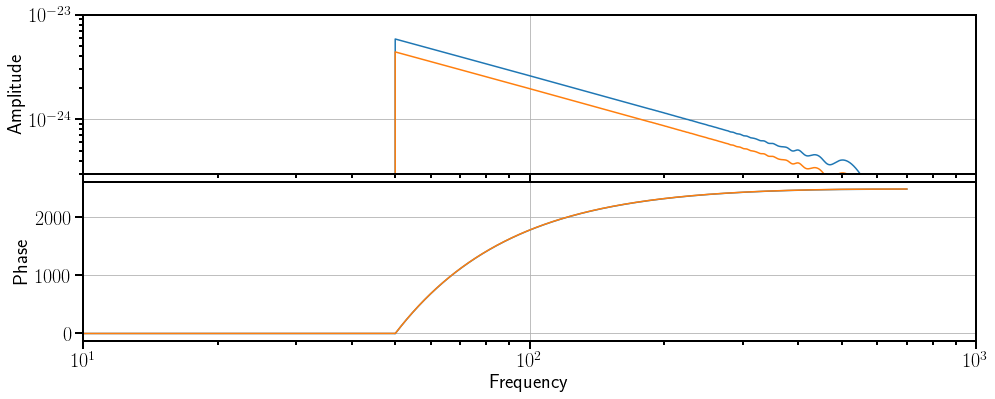

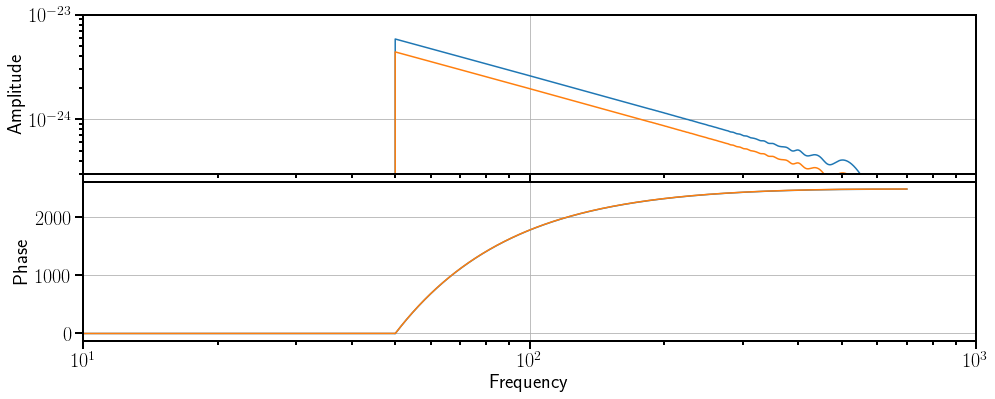

In [18]:
q, spin1z, spin2z, lambda1, lambda2 = params
mass2 = 1.4
mass1 = mass2/q
distance = 100.
inclination = 1.1
f_min = 50.
f_max = 700.
delta_f = 1.0e-2

freq, hp_lal, hc_lal = sur.physical_waveform_lal(
    mass1=mass1, mass2=mass2, 
    spin1z=spin1z, spin2z=spin2z, 
    lambda1=lambda1, lambda2=lambda2,
    distance=distance, inclination=inclination, 
    f_min=f_min, f_max=f_max, delta_f=delta_f, 
    f_ref=None, phi_ref=None)

hp_pycbc, hc_pycbc = sur.physical_waveform_pycbc(
    mass1=mass1, mass2=mass2, 
    spin1z=spin1z, spin2z=spin2z, 
    lambda1=lambda1, lambda2=lambda2,
    distance=distance, inclination=inclination, 
    f_min=f_min, f_max=f_max, delta_f=delta_f, 
    f_ref=None, phi_ref=None)

hp_lal = wave.Waveform.from_complex(freq, hp_lal)
hc_lal = wave.Waveform.from_complex(freq, hc_lal)

hp_pycbc = wave.Waveform.from_complex(np.array(hp_pycbc.sample_frequencies), np.array(hp_pycbc))
hc_pycbc = wave.Waveform.from_complex(np.array(hc_pycbc.sample_frequencies), np.array(hc_pycbc))

fig, (ax1, ax2) = wave.plot_waveforms_fd([hp_lal, hc_lal])
ax1.set_yscale('log')
ax1.grid()
ax2.grid()
ax1.set_ylim(3.0e-25, 1.0e-23)
ax2.set_xlim(10., 1000.)

fig, (ax1, ax2) = wave.plot_waveforms_fd([hp_pycbc, hc_pycbc])
ax1.set_yscale('log')
ax1.grid()
ax2.grid()
ax1.set_ylim(3.0e-25, 1.0e-23)
ax2.set_xlim(10., 1000.)

# Systematic error calculation

In [21]:
def surrogate_fisher_params(params, f_min, f_max, npoints=1000):
    """Wrapper for TaylorF2 with Fisher-matrix parameters.
    phase_order=4 corresponds to 2PN order.
    """
    lndist, f0tc, phic, lnmc, lneta, ssym, santi, tlambda, dtlambda = params
    
    distance = np.exp(lndist)
    mc = np.exp(lnmc)
    eta = np.exp(lneta)
    
    mass1 = fisher.m1_of_mchirp_eta(mc, eta)
    mass2 = fisher.m2_of_mchirp_eta(mc, eta)
    spin1z, spin2z = fisher.s1_s2_of_pe_params(ssym, santi)
    lambda1, lambda2 = fisher.lam1_lam2_of_pe_params(eta, tlambda, dtlambda)
    
    #print distance, f0tc, phic, mass1, mass2, spin1z, spin2z, lambda1, lambda2
    
    h = sur.physical_waveform_zero_inclination(
    mass1=mass1, mass2=mass2, 
    spin1z=spin1z, spin2z=spin2z, 
    lambda1=lambda1, lambda2=lambda2,
    distance=distance)
    
    # Resample waveform
    fs = np.logspace(np.log10(f_min), np.log10(f_max), npoints)
    h.resample(fs)
    
    # Set the phase at the last data point to phic
    h.phase += phic - h.phase[-1]
    
    # Shift the coalescence time by f0tc (add 2 \pi f f0tc to Fourier transformed phase)
    h.phase += 2.*np.pi*h.x*f0tc
    
    return h

In [24]:
def evaluate_statistical_systematic_errors(i, mass2, surrogate_fisher_params, testset, snr, psd_array):
    
    q, spin1z, spin2z, lambda1, lambda2 = testset.get_waveform(i, data='parameters')
    mass1 = mass2/q
    mtot = mass1 + mass2
    
    # Initial distance guess before knowing the snr
    distance0 = 100.
    
    f_min = 1.05*mf_to_f(sur.mf_a, mtot)
    f_max = 0.95*mf_to_f(sur.mf_b, mtot)
    
    mchirp = fisher.mchirp_of_m1_m2(mass1, mass2)
    eta = fisher.eta_of_m1_m2(mass1, mass2)
    
    # Fisher matrix parameters
    lndist0 = np.log(distance0)
    f0tc = 0.0
    phic = 0.0
    lnmc = np.log(mchirp)
    lneta = np.log(eta)
    ssym = fisher.ssym_of_s1_s2(spin1z, spin2z)
    santi = fisher.santisym_of_s1_s2(spin1z, spin2z)
    tlambda = fisher.lamtilde_of_eta_lam1_lam2(eta, lambda1, lambda2)
    dtlambda = fisher.deltalamtilde_of_eta_lam1_lam2(eta, lambda1, lambda2)
    params0 = [lndist0, f0tc, phic, lnmc, lneta, ssym, santi, tlambda, dtlambda]
    
    # Initialize Fisher matrix
    fisher_sur0 = fisher.NumericalFisher(surrogate_fisher_params, params0, f_min, f_max, psd_array)
    
    # Determine correct distance for given SNR
    snr0 = fisher_sur0.snr()
    distance = distance0 * (snr0/snr)
    params = list(params0)
    params[0] = np.log(distance)
    #print params0
    #print params
    # Now initialize Fisher matrix with correct distance
    fisher_sur = fisher.NumericalFisher(surrogate_fisher_params, params, f_min, f_max, psd_array)
    #print fisher_sur.snr()
    
    # Get exact waveform
    h_exact_geom = testset[i]
    h_exact = wave.dimensionless_to_physical_freq(h_exact_geom, mtot, distance)
    
    param_indices = [1, 2, 3, 4, 5, 6, 7]
    dthetas = [0, 0.001, 0.1, 0.001, 0.0001, 0.001, 0.001, 10.0, 0]
    dtypes = ['central', 'central', 'central', 'backward', 'central', 'central', 'central']
    
    if spin1z < -0.65 or spin2z < -0.65: 
        dtypes[4] = 'forward'
        dtypes[5] = 'forward'
    if spin1z > 0.65 or spin2z > 0.65: 
        dtypes[4] = 'backward'
        dtypes[5] = 'backward'

    if lambda1 < 100. or lambda2 < 100.: 
        dtypes[6] = 'forward'
    if lambda1 > 9900. or lambda2 > 9900.: 
        dtypes[6] = 'backward'
        
    prior_sigmas = [None, None, None, 0.25, 0.7, 0.7, None]
    
    fisher_sur.derivative_list_eval(param_indices, dthetas, dtypes)
    fisher_sur.fisher_matrix();
    fisher_sur.prior_matrix(prior_sigmas)
    cov = fisher_sur.covariance_matrix()
    stat_err = fisher_sur.get_sigmas()
    sys_err = fisher_sur.systematic_error(h_exact)
    
    #print 'Statistical error:'
    #print stat_err
    #print 'Systematic error:'
    #print sys_err
    #print 'Sys/Stat error'
    print sys_err/stat_err
    
    return sys_err/stat_err

In [25]:
mass2 = 1.05
testset = testset_rand
snr = 15.

# The file is actually an ASD not a PSD
psd_array = np.loadtxt('/Users/lackey/Research/NoiseCurves/LIGO/ZERO_DET_high_P.txt') 
psd_array[:, 1] = psd_array[:, 1]**2

err_list = []
for i in range(len(testset)):
    err = evaluate_statistical_systematic_errors(i, mass2, surrogate_fisher_params, testset, snr, psd_array)
    err_list.append(err)

[ 0.995  -1.0404  0.1492 -0.5809  0.1708  0.037   0.2357]
[ 0.0313  0.0324 -0.2697 -0.2193 -0.3382  0.2985 -0.4579]
[-0.2038  0.0246 -0.0109 -0.0737  0.0078  0.0202  0.0601]
[ 0.2621 -0.2557 -0.0377 -0.2802 -0.3584  0.2796 -0.2538]
[ 0.0468 -0.037  -0.0232 -0.0047 -0.0002  0.0008 -0.0355]
[-0.4877  0.348   0.0967  0.0133 -0.2945  0.323   0.126 ]
[ 0.1701 -0.2462 -0.3378 -0.5198 -0.1021  0.2284 -0.6545]
[-0.5478  0.4698 -0.6951  0.2247 -0.1586 -0.1647 -0.0705]
[ 0.7633 -0.8387 -0.4321 -0.9698 -0.8579 -0.4214 -0.6852]
[ 0.2394 -0.418  -0.1053 -0.531   0.5416 -0.2333 -0.6001]
[-0.3132  0.362  -0.3602 -0.4896  0.3355  0.0557 -0.8589]
[ 0.0121 -0.0766 -0.3364  0.1504 -0.5577  0.56   -0.074 ]
[ 0.0937 -0.0109 -0.0043 -0.0259  0.017  -0.0016 -0.0647]
[ 0.0751 -0.1745 -0.5171 -0.1791 -0.7916  0.6698 -0.3546]
[ 0.0094 -0.0714 -0.019  -0.0441 -0.0436 -0.004  -0.0166]
[ 0.3957 -0.3739 -0.1918 -0.5786  0.3152 -0.1821 -0.639 ]
[ 0.1367 -0.2326  0.0367 -0.1757  0.0916 -0.021  -0.0312]
[ 0.2641 -0.17

In [26]:
np.sort(np.abs(np.array(err_list)[:, 6]))

array([ 0.0097,  0.0153,  0.0166,  0.0241,  0.0307,  0.0312,  0.0332,  0.0355,  0.056 ,  0.0589,  0.0601,  0.061 ,  0.0624,  0.0647,  0.0682,  0.0693,
        0.0705,  0.0718,  0.074 ,  0.0882,  0.09  ,  0.0904,  0.0937,  0.1003,  0.1094,  0.1157,  0.1175,  0.126 ,  0.1267,  0.1297,  0.1308,  0.1373,
        0.1437,  0.1457,  0.1812,  0.1854,  0.1884,  0.1884,  0.1944,  0.2053,  0.2203,  0.229 ,  0.2353,  0.2357,  0.2538,  0.2723,  0.2759,  0.2772,
        0.2883,  0.3252,  0.3386,  0.3546,  0.3567,  0.3579,  0.3622,  0.3654,  0.3895,  0.3969,  0.399 ,  0.4237,  0.4559,  0.4579,  0.4582,  0.4652,
        0.4869,  0.4896,  0.4917,  0.5122,  0.5183,  0.5343,  0.5448,  0.5514,  0.5537,  0.5606,  0.5795,  0.6001,  0.6084,  0.6204,  0.6251,  0.639 ,
        0.6408,  0.6461,  0.6532,  0.6545,  0.6852,  0.6966,  0.7017,  0.7189,  0.7396,  0.7445,  0.7737,  0.7881,  0.8413,  0.8589,  0.8889,  0.9309,
        0.9458,  1.5736,  1.5898,  1.6983])

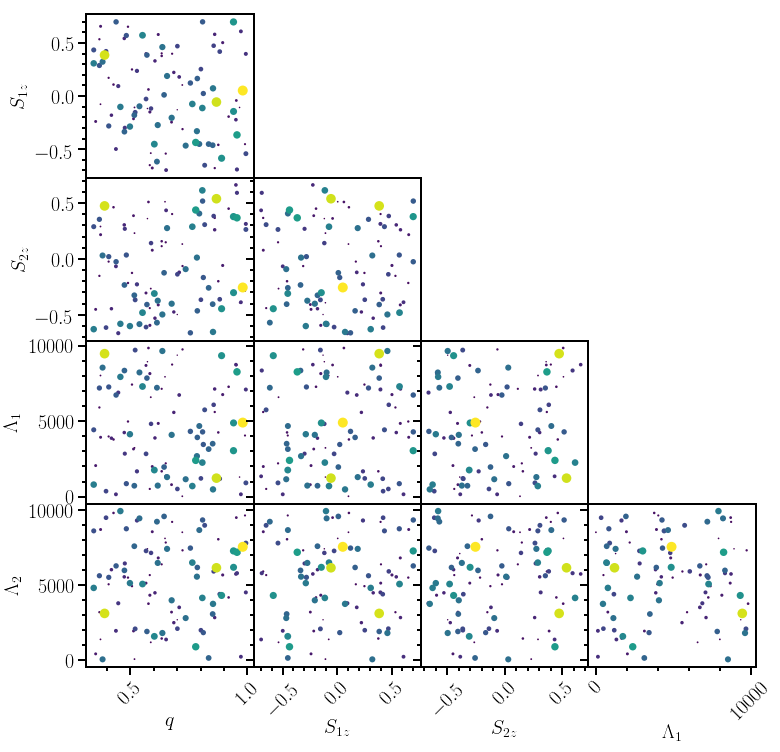

In [27]:
labels = [r'$q$', r'$S_{1z}$', r'$S_{2z}$', r'$\Lambda_1$', r'$\Lambda_2$']

params = testset_rand.parameters()
error = np.abs(np.array(err_list))[:, 6]
fig, ax = diagnostics.error_2d_triangle_plot(params, error, labels, threshold=None, figsize=(10, 10))


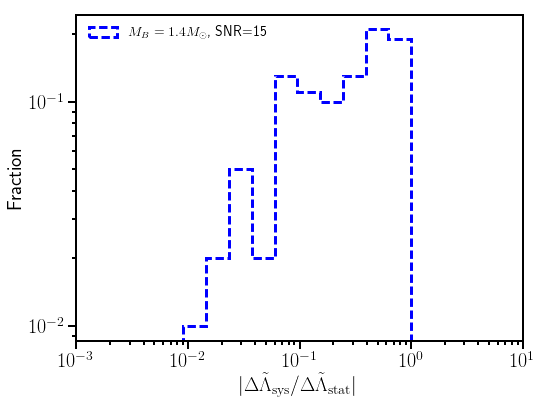

In [33]:
fig, axes = plt.subplots(1, figsize=(8, 6))

Nsamp = len(err_list)
error = np.abs(np.array(err_list))[:, 6]
axes.hist(error, bins=np.logspace(-10, 0, 50), weights=np.ones(Nsamp)/Nsamp, histtype='step', 
          ls='--', lw=3, color='blue', alpha=1.0, label=r'$M_B=1.4M_\odot$, SNR=15')

# Nsamp = len(params_mm_20)
# axes.hist(params_mm_20[:, 5], bins=np.logspace(-10, 0, 50), weights=np.ones(Nsamp)/Nsamp, histtype='step', 
#           ls='-', lw=3, color='green', alpha=1.0, label=r'$M_B=2.0M_\odot$')

axes.set_xscale("log")
axes.set_yscale("log")
axes.set_xlim([1.0e-3, 1.0e1])
#axes.set_ylim([1, 1.0e8])
axes.set_xlabel(r'$|\Delta\tilde\Lambda_{\rm sys} / \Delta\tilde\Lambda_{\rm stat}|$')
axes.set_ylabel(r'Fraction')
axes.legend(loc='upper left', frameon=False)
#fig.savefig('/home/bdlackey/public_html/ROM/mismatchhist.pdf', format='pdf', transparent=True, bbox_inches='tight')